In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score 
from factor_analyzer import FactorAnalyzer


In [2]:
df1=pd.read_csv('data/stock_profit.csv')[['code','npMargin','netProfit','MBRevenue','epsTTM','totalShare','liqaShare']]
df2=pd.read_csv('data/stock_growth.csv')[['code','YOYEquity','YOYEPSBasic','YOYNI']]
df3=pd.read_csv('data/stock_balance.csv')[['code','liabilityToAsset','currentRatio','assetToEquity','YOYLiability']]
df4=pd.read_csv('data/stock_dupont.csv')[['code','dupontAssetTurn']]
df5=pd.read_csv('data/stock_industry.csv', encoding='GBK')[['code','code_name','industry']]
df6=pd.read_csv('data/stock_k_data(2024_01_02).csv')[['code','open','volume']]

In [3]:
df=pd.merge(df1,df2,on='code')
df=pd.merge(df,df3,on='code')
df=pd.merge(df,df4,on='code')
df=pd.merge(df,df5,on='code')
df=pd.merge(df,df6,on='code')
df=df.dropna().reset_index(drop=True)

df.head(2)
# df.to_csv('./data/merged.csv')
df7=pd.read_csv('data/stock_k_data(2023_09_01).csv')[['code','open','volume']]
df7.rename(columns={
    'open': 'open_91',
    'volume': 'volume_91'
}, inplace=True)
df=pd.merge(df,df7,on='code')
df['open_dif']=df['open']-df['open_91']
df['volume_dif']=df['volume']-df['volume_91']
df=df.dropna().reset_index(drop=True)
df.head(2)
print(df.shape,df.columns)

(4320, 23) Index(['code', 'npMargin', 'netProfit', 'MBRevenue', 'epsTTM', 'totalShare',
       'liqaShare', 'YOYEquity', 'YOYEPSBasic', 'YOYNI', 'liabilityToAsset',
       'currentRatio', 'assetToEquity', 'YOYLiability', 'dupontAssetTurn',
       'code_name', 'industry', 'open', 'volume', 'open_91', 'volume_91',
       'open_dif', 'volume_dif'],
      dtype='object')


## 各行业每股收益均值

d:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


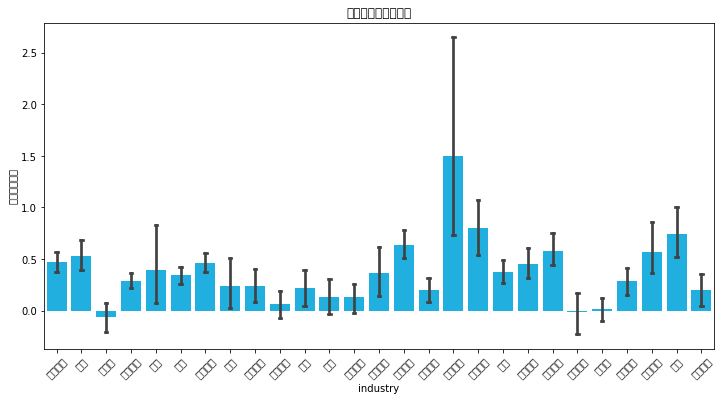

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置中文字体
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.figure(figsize=(12, 6))

sns.barplot(x="industry", y="epsTTM", data=df, color='deepskyblue', capsize=0.1)

plt.ylabel("每股收益均值")
plt.title("各行业每股收益均值")
plt.xticks(rotation=45)  # 旋转x轴标签以避免重叠

plt.show()


In [5]:
df['industry'].value_counts()


机械设备    470
化工      427
医药生物    393
电子      340
计算机     266
电气设备    240
汽车      210
公用事业    203
传媒      162
建筑装饰    151
轻工制造    151
有色金属    133
交通运输    125
食品饮料    120
房地产     116
通信      109
农林牧渔     93
纺织服装     93
商业贸易     91
国防军工     88
建筑材料     72
家用电器     69
采掘       64
综合       38
休闲服务     36
钢铁       35
非银金融     25
Name: industry, dtype: int64

## 化工、医药生物、机械设备 各列数据分布(IQR方法去除异常值)

In [6]:
chem_df=df[(df['industry']=='化工')|(df['industry']=='医药生物')|(df['industry']=='机械设备')]

In [7]:
chem_df.columns

Index(['code', 'npMargin', 'netProfit', 'MBRevenue', 'epsTTM', 'totalShare',
       'liqaShare', 'YOYEquity', 'YOYEPSBasic', 'YOYNI', 'liabilityToAsset',
       'currentRatio', 'assetToEquity', 'YOYLiability', 'dupontAssetTurn',
       'code_name', 'industry', 'open', 'volume', 'open_91', 'volume_91',
       'open_dif', 'volume_dif'],
      dtype='object')

In [8]:
selected_columns=[ 'npMargin', 'netProfit', 'MBRevenue', 'epsTTM', 'totalShare',
       'liqaShare', 'YOYEquity', 'YOYEPSBasic', 'YOYNI', 'liabilityToAsset',
       'currentRatio', 'assetToEquity', 'YOYLiability', 'dupontAssetTurn',
       'open_dif', 'volume_dif']

d:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
d:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
d:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a 

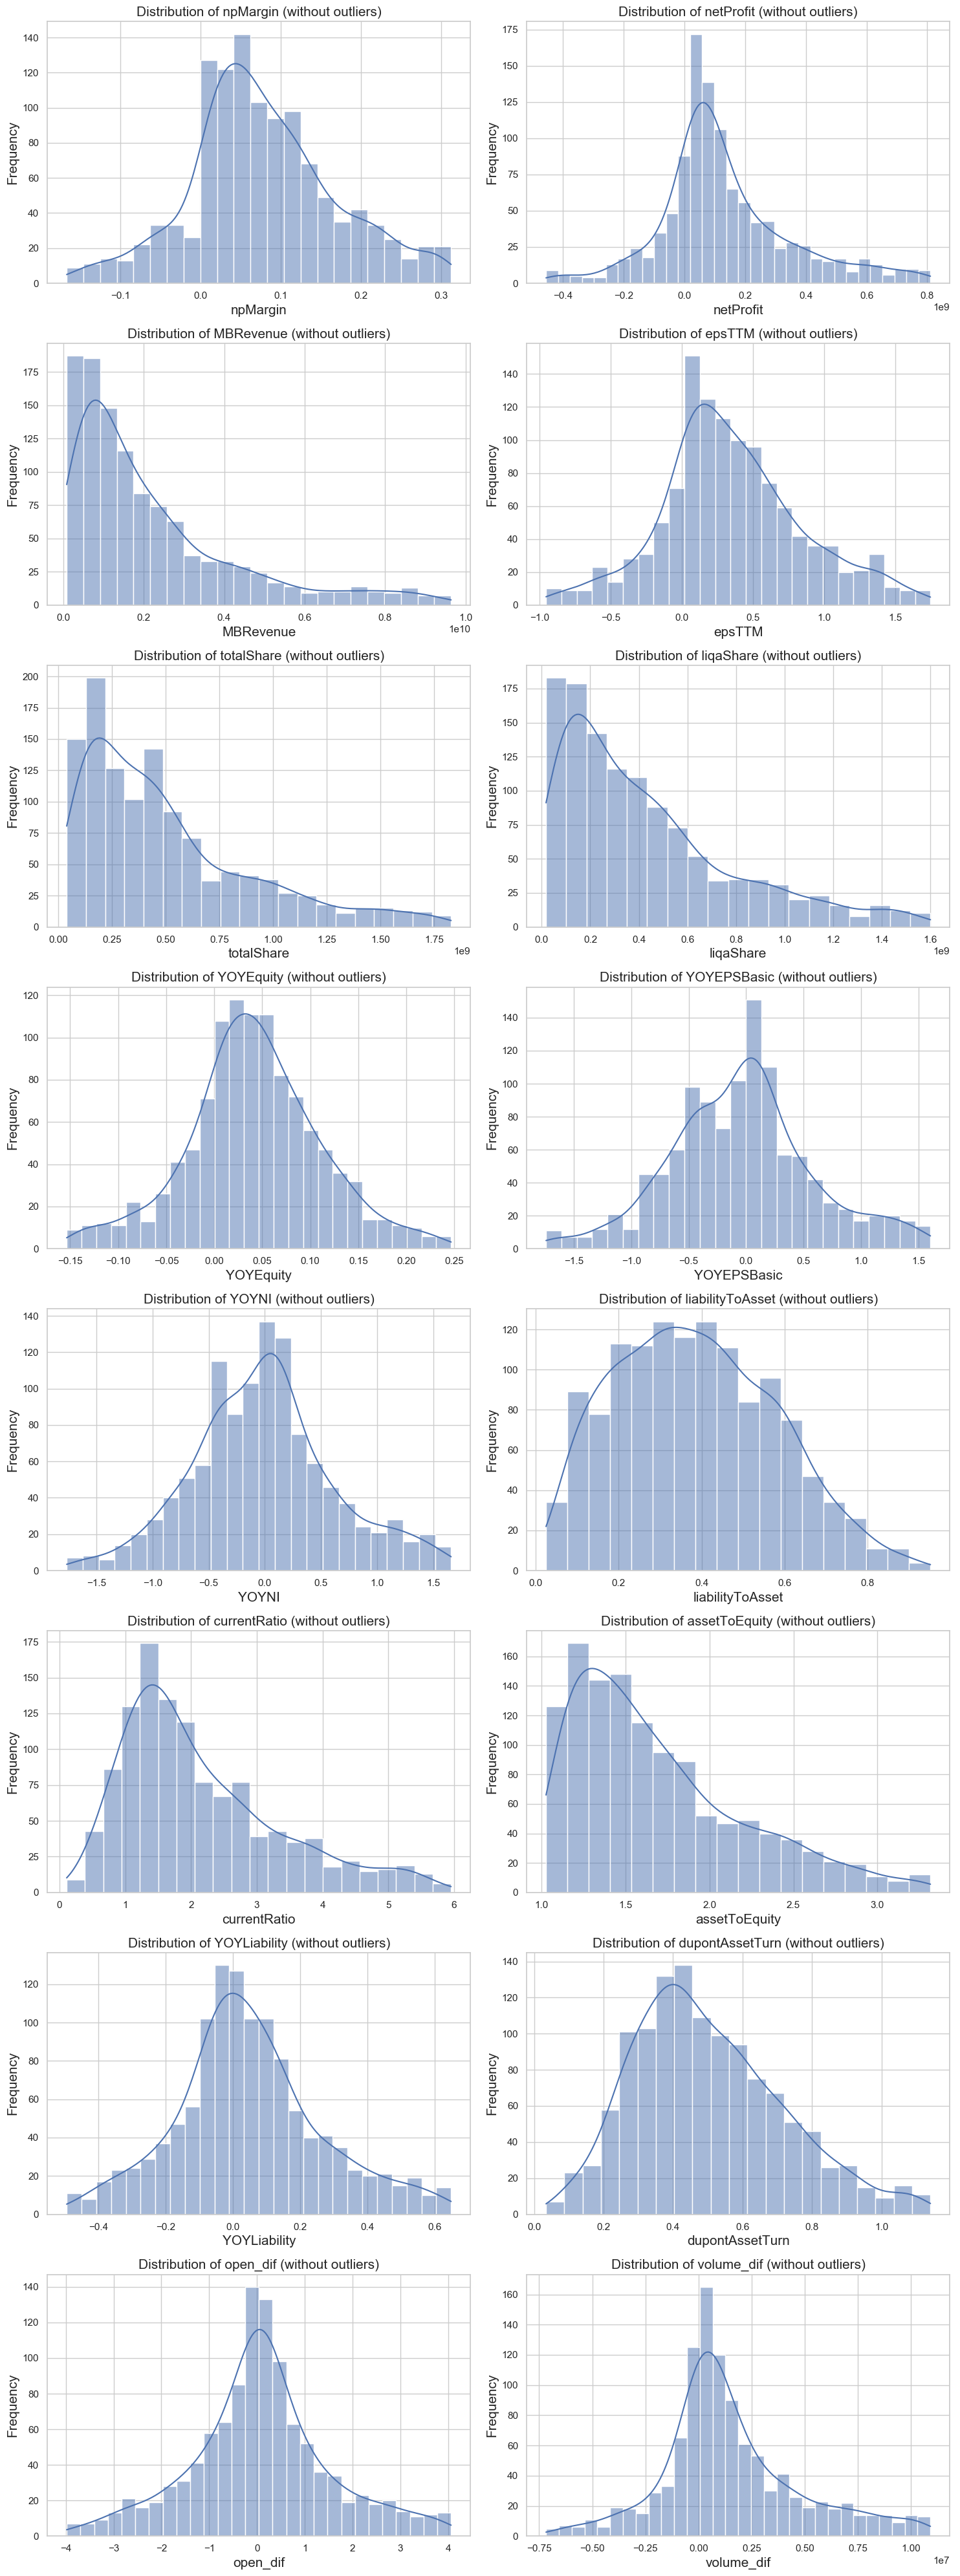

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 假设chem_df和selected_columns已定义
# 设置绘图风格
sns.set(style="whitegrid")

# 确定子图的行数和列数
num_columns = len(selected_columns)
num_rows = (num_columns + 1) // 2  # 每行放置两个子图

# 创建子图
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5),dpi=100)

# 遍历每一列并绘制分布图
for i, column in enumerate(selected_columns):
    row = i // 2
    col = i % 2
    
    # 计算IQR
    Q1 = chem_df[column].quantile(0.25)
    Q3 = chem_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 去掉异常值
    non_outliers = chem_df[(chem_df[column] >= lower_bound) & (chem_df[column] <= upper_bound)]
    
    # 绘制去除异常值后的分布图
    sns.histplot(non_outliers[column], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {column} (without outliers)',fontsize=15)
    axes[row, col].set_xlabel(column,fontsize=15)
    axes[row, col].set_ylabel('Frequency',fontsize=15)
    

# 调整布局
plt.tight_layout()
plt.show()


## 各列相关性热力图

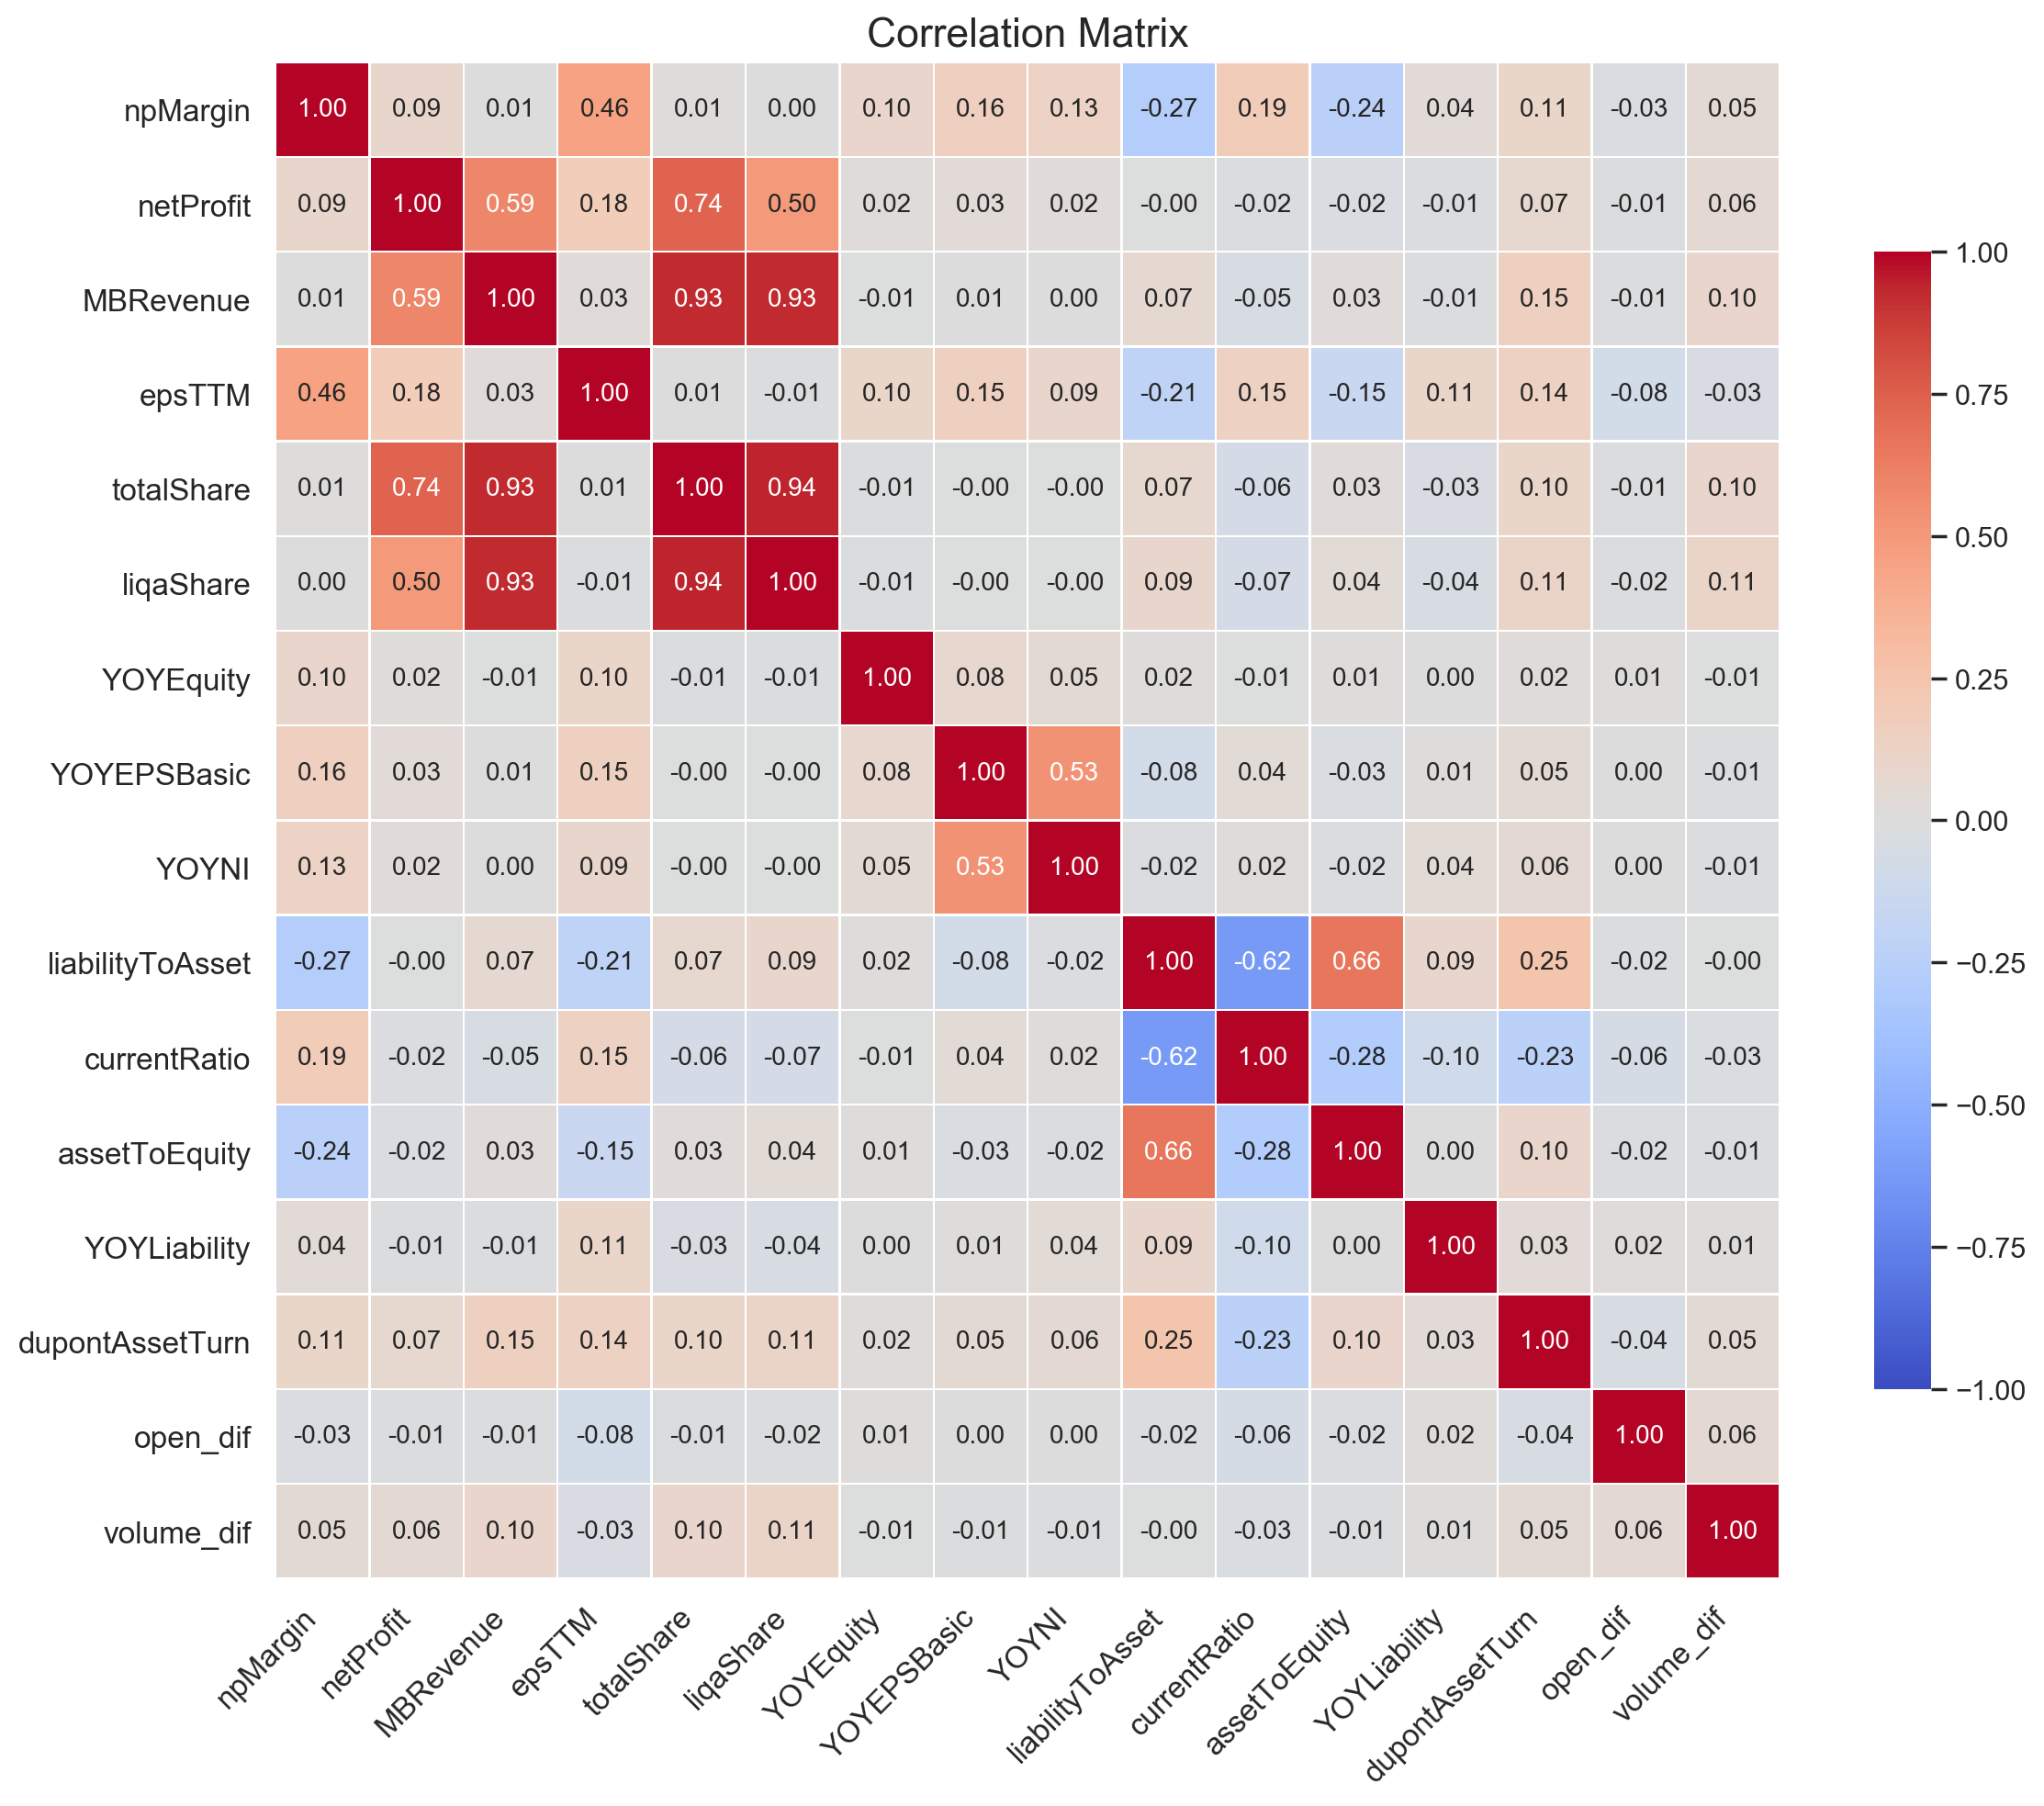

In [16]:

# 计算相关性矩阵
correlation_matrix = chem_df[selected_columns].corr()

# 绘制相关性热图
plt.figure(figsize=(12, 10),dpi=200)  # 增大图像尺寸
heatmap = sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    center=0, 
    annot_kws={"size": 10},  # 调整注释的字体大小
    fmt=".2f",  # 控制注释的格式
    linewidths=.5,  # 增加格子之间的间隔
    cbar_kws={"shrink": 0.75}  # 调整颜色条的尺寸
)
plt.title('Correlation Matrix', fontsize=16)  # 调整标题字体大小
plt.xticks(rotation=45, ha='right', fontsize=12)  # 调整x轴标签字体大小和旋转角度
plt.yticks(fontsize=12)  # 调整y轴标签字体大小
plt.tight_layout()  # 自动调整子图参数以填充整个图形区域
plt.show()

## 筛选出相关性大于0.6的列pair，研究是否具有线性关系

d:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


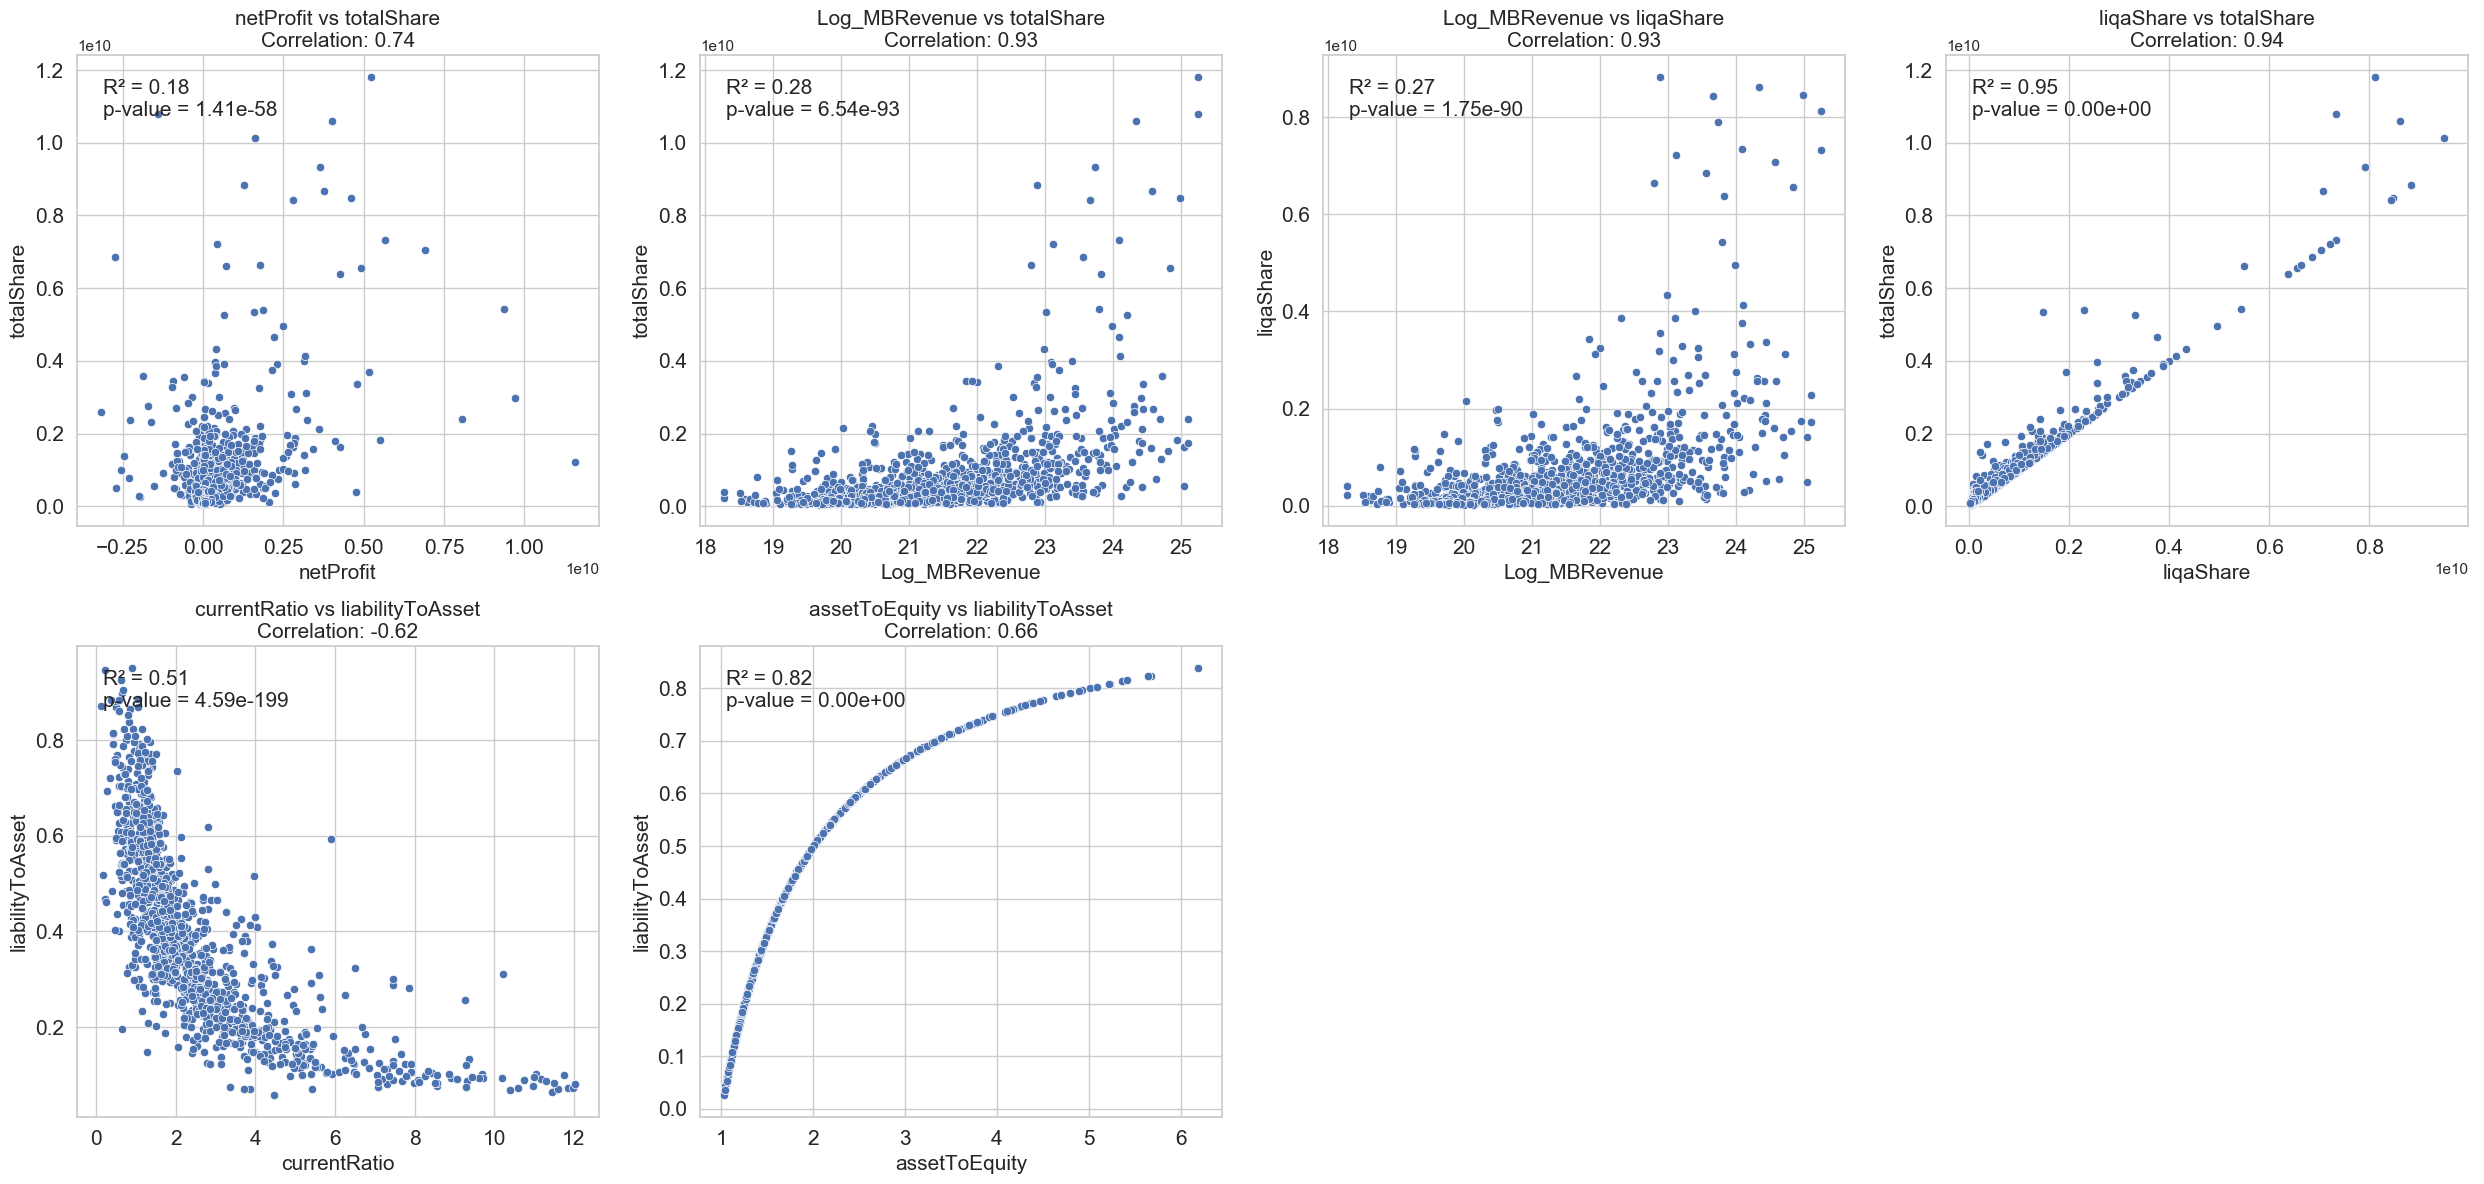

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
import statsmodels.api as sm

# 对 MBRevenue 列取对数（加 1 以避免 log(0) 问题）
if 'MBRevenue' in chem_df[selected_columns].columns:
    chem_df['Log_MBRevenue'] = np.log1p(chem_df['MBRevenue'])

# 计算相关性矩阵（包括对数后的 MBRevenue）
correlation_matrix = chem_df[selected_columns].corr()

# 设置阈值
threshold = 0.6

# 找出大于阈值的相关性对
high_corr_pairs = correlation_matrix[(abs(correlation_matrix) > threshold) & (abs(correlation_matrix) < 1)]

# 获取相关性对的列和行索引
high_corr_pairs = high_corr_pairs.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# 去除重复的对（例如 (A, B) 和 (B, A)）
high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['Feature1'] < high_corr_pairs['Feature2']]

# 创建子图
num_plots = len(high_corr_pairs)
num_cols = 4
num_rows = (num_plots // num_cols) + int(num_plots % num_cols != 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, num_rows * 6), dpi=100)
axes = axes.flatten()

# 绘制散点图并进行线性拟合
for i, (feature1, feature2, corr) in enumerate(high_corr_pairs.values):
    # 如果 MBRevenue 在特征对中，用 Log_MBRevenue 替换
    if feature1 == 'MBRevenue':
        feature1 = 'Log_MBRevenue'
    if feature2 == 'MBRevenue':
        feature2 = 'Log_MBRevenue'

    # 去除异常值（使用Z分数法）
    df_ = chem_df[[feature1, feature2]].dropna()
    z_scores = np.abs(zscore(df_))
    filtered_entries = (z_scores < 3).all(axis=1)
    filtered_df = df_[filtered_entries]
    
    # 散点图
    sns.scatterplot(x=filtered_df[feature1], y=filtered_df[feature2], ax=axes[i])
    
    # 线性拟合
    X = filtered_df[feature1]
    y = filtered_df[feature2]
    X_with_const = sm.add_constant(X)  # 添加截距项
    model = sm.OLS(y, X_with_const).fit()
    y_pred = model.predict(X_with_const)
    
    # # 绘制拟合线
    # sns.lineplot(x=X, y=y_pred, color='red', ax=axes[i])
    
    # 获取R²值和p值
    r_squared = model.rsquared
    p_value = model.f_pvalue
    
    # 在图中显示R²值和p值
    axes[i].text(0.05, 0.95, f'R² = {r_squared:.2f}\np-value = {p_value:.2e}', 
                 transform=axes[i].transAxes, fontsize=15, verticalalignment='top')
    
    # 设置标题和标签
    axes[i].set_title(f'{feature1} vs {feature2}\nCorrelation: {corr:.2f}', fontsize=15)
    axes[i].set_xlabel(feature1, fontsize=15)
    axes[i].set_ylabel(feature2, fontsize=15)
    axes[i].tick_params(axis='both', which='major', labelsize=15)

# 隐藏多余的子图
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 研究不同行业间（化工、生物医药、机械设备间）哪些变量的均值具有显著性差异的ANOVA，筛选出具有显著性差异的列

In [12]:
from scipy.stats import f_oneway

for i in selected_columns:
# 假设有三个组的数据
    group1 = chem_df[chem_df['industry']=='化工'][i]
    group2 = chem_df[chem_df['industry']=='医药生物'][i]
    group3 = chem_df[chem_df['industry']=='机械设备'][i]

    # 进行一元ANOVA检验
    f_statistic, p_value = f_oneway(group1, group2, group3)

    # 输出结果
    

    # 判断是否拒绝零假设
    alpha = 0.05
    if p_value < alpha:
        print(i)
        print(f"化工: {group1.mean()}, 医药生物: {group2.mean()}, 机械设备: {group3.mean()}")
        print("F统计量:", f_statistic)
        print("p值:", p_value)
        print("拒绝零假设，组间均值存在显著差异。" ,end="\n \n")

epsTTM
化工: 0.3407848571428567, 医药生物: 0.6382501832061067, 机械设备: 0.46327492340425547
F统计量: 7.2720093937795225
p值: 0.000723632490076425
拒绝零假设，组间均值存在显著差异。
 
liabilityToAsset
化工: 0.41177168384074925, 医药生物: 0.3223930941475828, 机械设备: 0.41782109787234045
F统计量: 33.22203066669538
p值: 8.549779588528428e-15
拒绝零假设，组间均值存在显著差异。
 
currentRatio
化工: 2.428655733021078, 医药生物: 3.6321560941475814, 机械设备: 2.618542791489361
F统计量: 18.663426236711345
p值: 1.0230417651776446e-08
拒绝零假设，组间均值存在显著差异。
 
assetToEquity
化工: 2.0932346533957826, 医药生物: 1.6572127302798985, 机械设备: 2.026989455319151
F统计量: 10.602296881076997
p值: 2.710200375114912e-05
拒绝零假设，组间均值存在显著差异。
 
YOYLiability
化工: 0.17394530913348938, 医药生物: 0.06011633842239187, 机械设备: 0.1473863680851065
F统计量: 7.692910104571997
p值: 0.00047733607576308507
拒绝零假设，组间均值存在显著差异。
 
dupontAssetTurn
化工: 0.6505820281030442, 医药生物: 0.503746865139949, 机械设备: 0.48498811276595744
F统计量: 40.07335814133722
p值: 1.3084672183519016e-17
拒绝零假设，组间均值存在显著差异。
 
open_dif
化工: -0.5207259953161592, 医药生物: 1.0

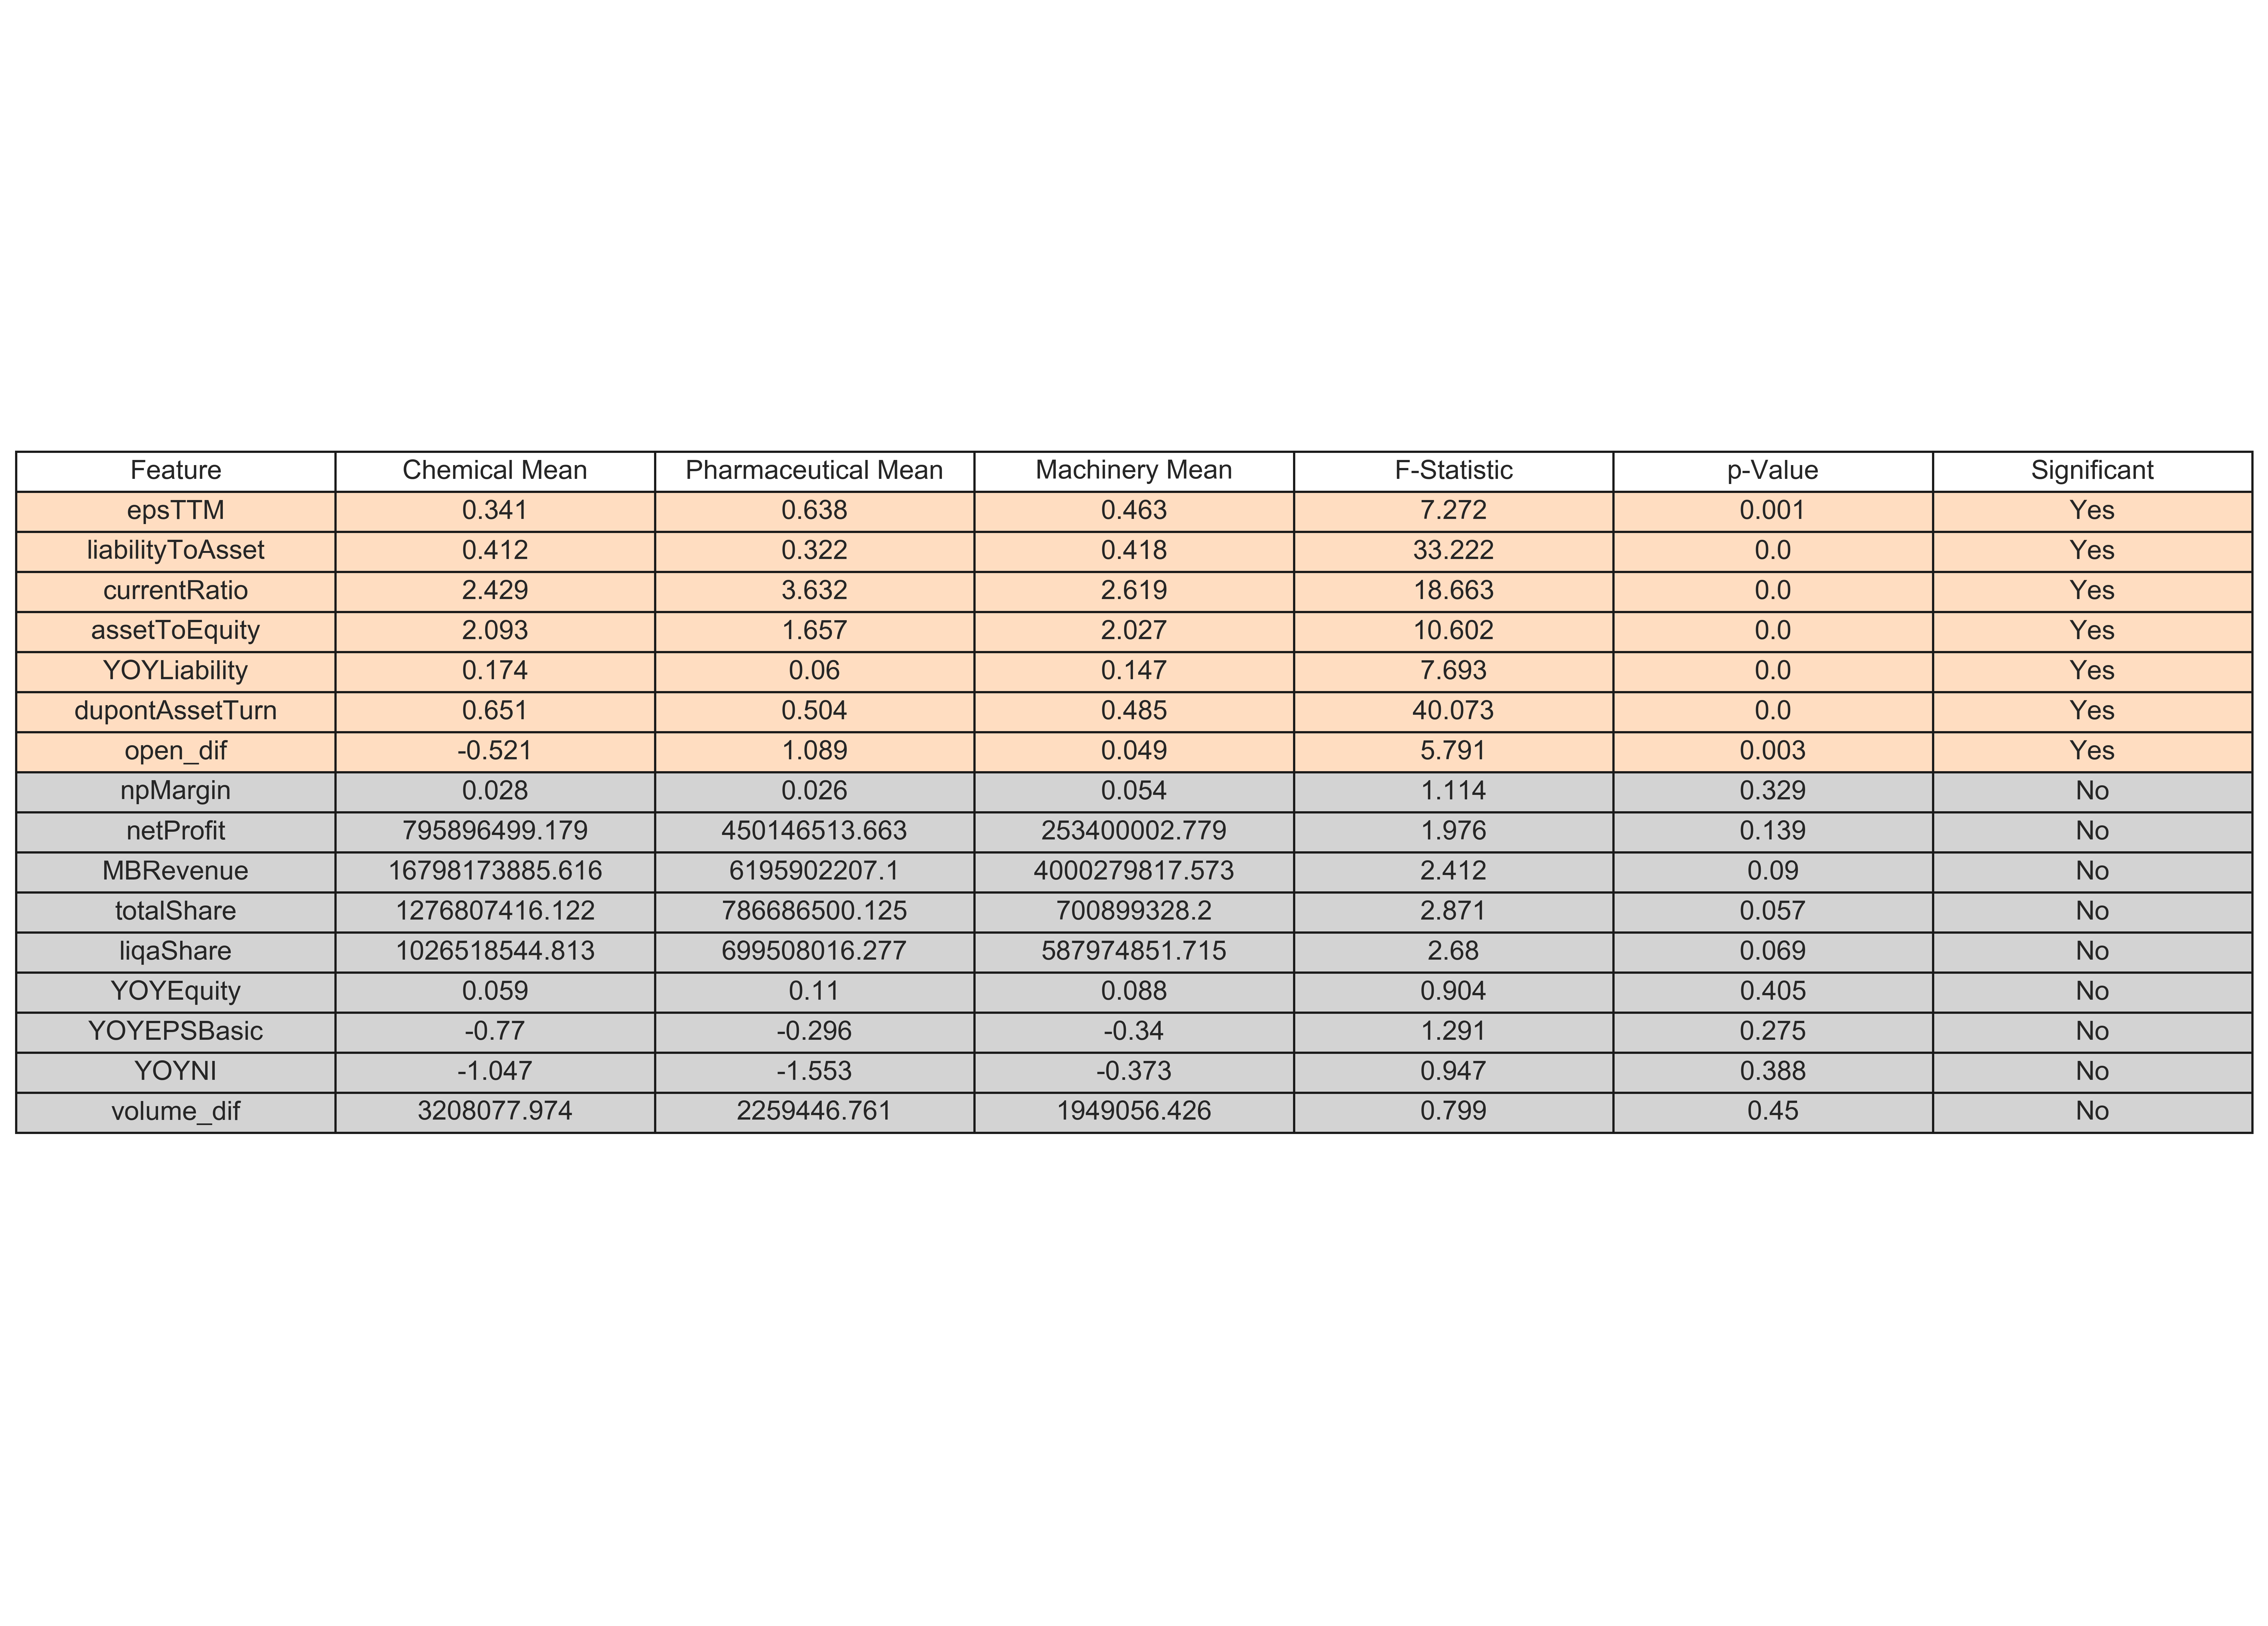

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import numpy as np

# 创建一个空的DataFrame用于存储结果
anova_results = pd.DataFrame(columns=['Feature', 'Chemical Mean', 'Pharmaceutical Mean', 'Machinery Mean', 'F-Statistic', 'p-Value', 'Significant'])

# 进行ANOVA检验并保存结果
for i in selected_columns:
    # 假设有三个组的数据
    group1 = chem_df[chem_df['industry'] == '化工'][i]
    group2 = chem_df[chem_df['industry'] == '医药生物'][i]
    group3 = chem_df[chem_df['industry'] == '机械设备'][i]

    # 进行一元ANOVA检验
    f_statistic, p_value = f_oneway(group1, group2, group3)

    # 判断是否拒绝零假设
    alpha = 0.05
    significant = 'Yes' if p_value < alpha else 'No'

    # 添加结果到DataFrame
    anova_results = anova_results.append({
        'Feature': i,
        'Chemical Mean': round(group1.mean(), 3),
        'Pharmaceutical Mean': round(group2.mean(), 3),
        'Machinery Mean': round(group3.mean(), 3),
        'F-Statistic': round(f_statistic, 3),
        'p-Value': round(p_value, 3),
        'Significant': significant
    }, ignore_index=True)

# 将Significant为Yes的行提到最上面
anova_results = anova_results.sort_values(by='Significant', ascending=False).reset_index(drop=True)

# 设置显示格式
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 绘制表格并保存为图片
fig, ax = plt.subplots(figsize=(12, len(anova_results) * 0.8), dpi=500)  # 增大图片高度
ax.axis('tight')
ax.axis('off')

# 创建表格
colors = plt.cm.BuGn(np.linspace(0, 0.5, len(anova_results)))
table = ax.table(cellText=anova_results.values, colLabels=anova_results.columns, cellLoc='center', loc='center', colColours=["white"]*len(anova_results.columns))

# 设置表格字体大小和颜色
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

# 逐行设置背景颜色
for i in range(len(anova_results)):
    if anova_results.loc[i, 'Significant'] == 'Yes':
        for j in range(len(anova_results.columns)):
            table[i+1, j].set_facecolor('#FFDDC1')  # 显著行设置为橙色
    else:
        for j in range(len(anova_results.columns)):
            table[i+1, j].set_facecolor('lightgrey')  # 非显著行设置为灰色

# 保存为图片
plt.savefig('anova_results.png', bbox_inches='tight', dpi=100)
plt.show()
